<a href="https://colab.research.google.com/github/jsokolowska/siema-my-z-mechatro/blob/main/kod-piklowy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
=====


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
import plotly.express as px

In [ ]:
data_path = "/content/drive/MyDrive/Data/hackathon/final_train.csv"

df = pd.read_csv(data_path, index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56",...,"tGravityAcc-correlation()-Y,Z",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,2.942713,5.837147,2.957527,-1.770934,-5.580564,13.725027,1.724643,-0.519345,4.233416,0.953127,0.807692,2.624547,-3.005993,3.329588,2.866778,...,2.988204,1.531084,-3.422785,1.852121,8.394366,3.246233,0.937300,4.725389,-1.578871,-0.442374,4.068593,4.705346,7.195449,-6.003664,0.607255,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,2.908602,5.819734,2.551773,-1.756530,-5.503246,13.251491,1.714753,-0.552312,3.566532,0.922455,0.726768,2.081277,-3.081267,3.140684,2.684137,...,2.859864,1.585023,-3.387872,1.698743,8.112279,1.926083,2.348895,4.719540,-1.521161,-0.463599,4.063648,4.730261,7.221653,-5.789276,0.417687,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,2.957325,5.841023,2.974139,-1.775050,-5.600164,13.743085,1.726239,-0.505341,4.256780,0.957134,0.831419,2.640759,-2.999393,3.359696,2.868557,...,3.717038,1.851578,-4.07074

In [ ]:
X = df.drop("Activity", axis=1)
y = df["Activity"]

Analiza danych 
===


In [ ]:
print(df.shape)
#col = df.columns.to_list()
#col

(11086, 572)


Znaczenie kolumn na pierwszy rzut oka nie jest jasne, jednak chwila przeszukiwania internetu i można znaleźć dobre wyjaśnienie tych danych np. https://github.com/KarthikMurugadoss1804/Human-Activity-Recognition.

Jednak pewne atrybuty od początku wzbudzają wątpliwości, np. atrybut void() wydaje się być zupełnie przypadkowo dodany. Pozostałe atrybuty wydają sie sensownie dobrane. 

Można też zauważyć pewną powtarzalność - są "sparowane" atrybuty zaczynające się od t lub od f, które zgodnie z podlinkowanych artykułek powstały po zastosowaniu transformaty fouriera dla atrybutów zaczynających się od "t". To potencjalna redundacja, którą prawdopodobnie można bezstratnie usunąć. 

In [ ]:
df["Activity"].unique()

array(['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS'], dtype=object)

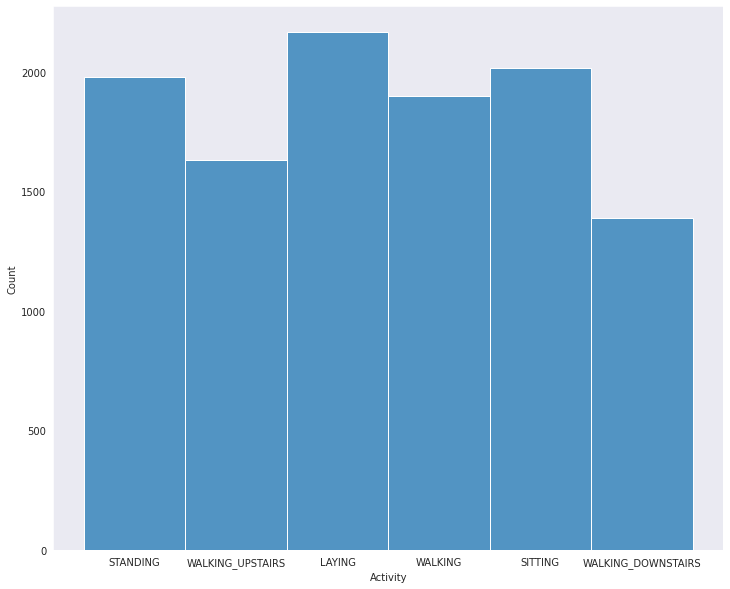

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.set_style("dark")
sns.histplot(df["Activity"], edgecolor='white')

Klasy są w miare równomniernie rozłożone, więc nie powinny powodować problemów podczas klasyfikacji. 

In [ ]:
# sprawdzenie jak wiele wartości jest pustych
df.isnull().sum()

Activity                                 0
angle(X,gravityMean)                    57
angle(Y,gravityMean)                    68
angle(Z,gravityMean)                    60
angle(tBodyAccJerkMean),gravityMean)    52
                                        ..
tGravityAccMag-mean()                   65
tGravityAccMag-min()                    66
tGravityAccMag-sma()                    57
tGravityAccMag-std()                    46
void()                                  65
Length: 572, dtype: int64

In [ ]:
# filling empty spaces with mean
df = df.fillna(df.mean())
df.isnull().sum() # sanity check

Activity                                0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
angle(tBodyAccJerkMean),gravityMean)    0
                                       ..
tGravityAccMag-mean()                   0
tGravityAccMag-min()                    0
tGravityAccMag-sma()                    0
tGravityAccMag-std()                    0
void()                                  0
Length: 572, dtype: int64

In [ ]:
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56",...,"tGravityAcc-correlation()-Y,Z",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,2.942713,5.837147,2.957527,-1.770934,-5.580564,13.725027,1.724643,-0.519345,4.233416,0.953127,0.807692,2.624547,-3.005993,3.329588,2.866778,...,2.988204,1.531084,-3.422785,1.852121,8.394366,3.246233,0.937300,4.725389,-1.578871,-0.442374,4.068593,4.705346,7.195449,-6.003664,0.607255,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,2.908602,5.819734,2.551773,-1.756530,-5.503246,13.251491,1.714753,-0.552312,3.566532,0.922455,0.726768,2.081277,-3.081267,3.140684,2.684137,...,2.859864,1.585023,-3.387872,1.698743,8.112279,1.926083,2.348895,4.719540,-1.521161,-0.463599,4.063648,4.730261,7.221653,-5.789276,0.417687,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,2.957325,5.841023,2.974139,-1.775050,-5.600164,13.743085,1.726239,-0.505341,4.256780,0.957134,0.831419,2.640759,-2.999393,3.359696,2.868557,...,3.717038,1.851578,-4.07074

Redukcja wymiarowości 
=====
Redukcja wymiarowości poprzez selekcję atrybutów

In [ ]:
# sprawdzenie korelacji atrybutów z atrybutem klasyfikacji
res = []
df_no_a = df.drop("Activity", axis=1)
labels = df["Activity"]

for f in df_no_a.columns:
  res.append(df[f].corr(labels, method='spearman'))

In [ ]:
col = df_no_a .columns.to_list()

correl = pd.DataFrame(res, index = col)
weak_f = correl[abs(correl[0]) < 0.3]

weak_f.index 

Index(['angle(tBodyAccMean,gravity)', 'angle(tBodyGyroJerkMean,gravityMean)',
       'angle(tBodyGyroMean,gravityMean)', 'energy-mean()',
       'fBodyAcc-kurtosis()-X', 'fBodyAcc-kurtosis()-Y',
       'fBodyAcc-kurtosis()-Z', 'fBodyAcc-main()-X', 'fBodyAcc-main()-Z',
       'fBodyAcc-maxInds-Y',
       ...
       'tGravityAcc-entropy()-Y', 'tGravityAcc-entropy()-Z',
       'tGravityAcc-iqr()-X', 'tGravityAcc-mad()-X', 'tGravityAcc-sma()',
       'tGravityAcc-std()-X', 'tGravityAccMag-arCoeff()4',
       'tGravityAccMag-mad()', 'tGravityAccMag-sma()', 'void()'],
      dtype='object', length=106)

Mamy w danych sporo atrybutów o niskiej korelacji z atrybutem klasyfikacji - prawdopodobnie bez wielkich strat dla dokładności modelu można je usunąć. Wśród nich jest też atrybut wcześniej wyróżniony jako podejrzany - "void()".


In [ ]:
# sprawdzenie korelacji odpowiadających sobie atrybutów f i t - podejrzewamy, że mogą wprowadzać redundancję
def inv_fourier(df, fourier_labels):
  inv_fourier_labels = [label.replace('f', 't', 1) for label in fourier_labels]
  return df.filter(items=inv_fourier_labels)

def fourier_correlation(df, inv_fourier_labels):
  results = pd.DataFrame(columns=['label', 'value'])
  for label in inv_fourier_labels:
    new_row = {'label': label[1:], 'value': df[label].corr(df[label.replace('t', 'f', 1)])}
    results = results.append(new_row, ignore_index=True)
  return results

fourier_labels = df.filter(regex='^f').columns
inv_fourier_labels = inv_fourier(df, fourier_labels)

correlation = fourier_correlation(df, inv_fourier_labels)

def filter_correlating_fourier(df, correlation, threshold=0.5):
  filtered = df.copy()
  for index, row in correlation.iterrows():
    if abs(float(row['value']) > 0.5):
      filtered = filtered.drop(columns=['f'+row['label']], errors='ignore')

  return filtered



no_fourier = filter_correlating_fourier(df, correlation)
print(no_fourier.shape, df.shape) # do usuniecia będzie niemal 50 atrybutów



(11086, 524) (11086, 572)


In [ ]:
# normalizacja
import sklearn.preprocessing as preprocessing
X = df.drop('Activity', axis='columns')
X = X.fillna(X.mean())

def normalize(df):
    cols = df.columns
    x = df.values # returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=cols)

X = normalize(X)

In [ ]:
# przykładowa klasyfikacja z wykorzystaniem wszystkich atrybutów
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

model_lr = LogisticRegression(random_state=69).fit(X_train, y_train)
best_score = model_lr.score(X_test, y_test)
best_score

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9822609741431149

In [ ]:
# zbiór atrybutów zredukowany o te nisko skorelowane z atrybutem docelowym
weak_f = correl[abs(correl[0]) < 0.5]

X_train_reduced = X_train.drop(weak_f.index, axis=1)
print(X_train.shape, X_train_reduced.shape, weak_f.shape) #sanity check

X_test_reduced = X_test.drop(weak_f.index, axis=1)
print(X_test.shape, X_test_reduced.shape, weak_f.shape) #sanity check


X_train_reduced.head()

(8868, 571) (8868, 418) (153, 1)
(2218, 571) (2218, 418) (153, 1)


,"angle(Y,gravityMean)","angle(Z,gravityMean)","fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56","fBodyAcc-bandsEnergy()-49,56.1","fBodyAcc-bandsEnergy()-49,56.2","fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-49,64.1","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-57,64","fBodyAcc-bandsEnergy()-57,64.1",...,tBodyGyroJerk-std()-Z,tBodyGyroJerkMag-energy(),tBodyGyroJerkMag-entropy(),tBodyGyroJerkMag-iqr(),tBodyGyroJerkMag-mad(),tBodyGyroJerkMag-max(),tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-min(),tBodyGyroJerkMag-sma(),tBodyGyroJerkMag-std(),tBodyGyroMag-energy(),tBodyGyroMag-iqr(),tBodyGyroMag-mad(),tBodyGyroMag-max(),tBodyGyroMag-mean(),tBodyGyroMag-min(),tBodyGyroMag-sma(),tBodyGyroMag-std(),tGravityAcc-energy()-Y,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-std()
1278,0.009843,-1.257162,-0.537703,-0.341473,1.576705,-0.561890,-0.274796,-1.525437,0.075957,-0.562914,-1.741297,0.709923,0.261648,-0.652598,0.644501,-0.283918,0.478868,-0.302999,0.330492,0.158987,-0.471353,-0.320008,-0.095018,-0.747420,0.253338,0.009265,-0.741679,0.257189,-0.059444,-0.670964,0.235534,-0.194014,-1.366710,-0.310628,0.578006,-1.575181,0.240679,-0.358124,-1.784856,0.079036,...,0.498780,-0.179661,-1.044837,-0.676940,-0.560106,-0.749524,-0.675108,-0.949678,-0.675570,0.604991,-1.455742,0.795221,-1.038952,-1.401031,-1.453829,0.476727,1.453189,-1.143953,0.611093,0.959735,-0.139256,0.832211,-0.114803,-0.106018,1.347740,-0.059840,1.337926,-0.020970,-1.317076,-0.789835,-0.060966,0.598796,-0.728873,-0.702212,1.049211,-0.841848,-0.896061,0.969655,0.913064,-0.871935
11018,1.446038,1.946786,0.685629,0.746860,-0.727059,0.697162,0.747655,0.736449,-0.633047,0.756588,0.706319,-0.664178,0.593761,0.566390,-0.668645,-0.601562,-0.560790,0.565450,0.525189,0.443066,0.612839,-0.559442,-0.467354,0.626719,0.535754,0.439661,0.633365,0.564112,0.483048,0.594731,0.553789,0.524863,0.598124,-0.514020,-0.544674,0.566460,0.468407,0.507622,0.475772,0.320054,...,-0.797655,0.566761,0.494190,0.762591,0.747248,0.742261,0.782079,0.713632,0.781862,-0.743387,0.764883,-0.828974,0.850982,0.857942,0.882380,-0.797190,-0.882598,0.857721,-1.145890,-0.523142,0.548025,-0.534380,0.544731,-1.521251,-1.874318,-1.539050,-1.882260,-1.552673,1.894302,0.535796,0.540802,-1.191134,1.025452,0.778960,-0.759681,0.861664,0.872379,-0.875639,-0.812256,0.867916
554,-1.034158,-0.408924,0.636877,0.667916,-0.508129,0.647539,0.675813,0.535615,-0.622171,0.658836,0.438616,-0.617645,0.587820,0.556555,-0.630121,-0.595444,-0.554574,0.562429,0.519491,0.449374,0.593520,-0.553001,-0.473017,0.594979,0.532591,0.455019,0.584940,0.556853,0.486686,0.524278,0.540332,0.503650,0.566822,-0.499362,-0.530753,0

In [ ]:
model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) # 0.969 czyli lekki, ale akceptowalny spadek

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9688908926961226

In [ ]:
# dodatkowa redukcja wewnętrznie skorelowaych atrybutów fouriera
X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)
print(X_train.shape, X_train_reduced.shape) #sanity check

X_test_reduced = filter_correlating_fourier(X_test_reduced,correlation )
print(X_test.shape, X_test_reduced.shape) #sanity check

model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) #0.966 czyli mały, zupełnie okej spadek

(8868, 571) (8868, 370)
(2218, 571) (2218, 370)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9666366095581606

Strojenie hiperparametrów redukcji atrybutów
====


In [ ]:
#strojenie hiperparametru progu usuwania atrybutów małoinformatywnych
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []

for th in thresholds:

  weak_f = correl[abs(correl[0]) < th]
  num.append(len(weak_f.index ))

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)
  print("----------------------", th)
  res.append(score)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.6
---------------------- 0.7


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.1 - 0.9810640216411182, dropeed 28 features. Difference to best score: 0.003155996393146898
Score for threshold 0.2 - 0.9792605951307484, dropeed 71 features. Difference to best score: 0.004959422903516697
Score for threshold 0.3 - 0.9801623083859333, dropeed 106 features. Difference to best score: 0.004057709648331742
Score for threshold 0.4 - 0.9747520288548241, dropeed 139 features. Difference to best score: 0.009467989179440917
Score for threshold 0.5 - 0.9666366095581606, dropeed 153 features. Difference to best score: 0.017583408476104512
Score for threshold 0.6 - 0.9192966636609559, dropeed 176 features. Difference to best score: 0.0649233543733092
Score for threshold 0.7 - 0.9116321009918846, dropeed 301 features. Difference to best score: 0.07258791704238043


Decydujemy się na próg 0.4 - pozwala zredukować wymiarowość o 139 atrybutów, a dokładność klasyfikacji spada o niecały punkt procentowy

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []
base = len(X_train.columns)

for th in thresholds:

  weak_f = correl[abs(correl[0]) < 0.4]

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation, th)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation, th)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)
  print("----------------------", th)
  num.append(base - len(X_train_reduced.columns))
  res.append(score)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---------------------- 0.6
---------------------- 0.7


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.3 - 0.9747520288548241, dropeed 187 features. Difference to best score: 0.009467989179440917
Score for threshold 0.4 - 0.9747520288548241, dropeed 187 features. Difference to best score: 0.009467989179440917
Score for threshold 0.5 - 0.9747520288548241, dropeed 187 features. Difference to best score: 0.009467989179440917
Score for threshold 0.6 - 0.9747520288548241, dropeed 187 features. Difference to best score: 0.009467989179440917
Score for threshold 0.7 - 0.9747520288548241, dropeed 187 features. Difference to best score: 0.009467989179440917


Zmiany progu nie powodują zmiany ilości wyrzucanych atrybutów, dlatego dla redundantnych atrybutów fouriera pozostaniemy przy progu domyślnym - 0.5

Interpretacja wyników
====


In [ ]:
from plotly.subplots import make_subplots


def most_important_features(X, model_lr, top_n=5):
    
    feature_importance = {}

    for i, aclass in enumerate(model_lr.classes_):
        importance = abs(model_lr.coef_[i])

        importance_df = pd.DataFrame(importance, columns=['Importance'])
        importance_df = importance_df.sort_values(by='Importance',ascending=False)
        top = importance_df[:top_n]
        top.index.name = 'Feature'
        top = top.reset_index()
        top['Feature'] = top['Feature'].map(lambda i: X.columns[i])
        #best_features = {X.columns[col]:importance for col, importance in top.itertuples()}
        feature_importance[aclass] = top
        
    return feature_importance


def plot_most_important_features(feature_importance):
    plt_titles = list(feature_importance.keys())
    length = len(feature_importance)
    
    fig = make_subplots(
        rows=len(feature_importance),
        cols=1,
        subplot_titles=plt_titles,
    )
    
    for i,top in enumerate(feature_importance.values()):
        f = px.bar(top, x='Feature', y='Importance')
        fig.add_trace(f.data[0], row = i + 1, col = 1)
    fig.update_layout(height=length * 350, width=900)
    #fig.update(layout_coloraxis_showscale=False)
    fig.show()

feature_importance = most_important_features(X, model_lr, top_n=8)
plot_most_important_features(feature_importance)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Activity", axis=1), labels, test_size=0.3, random_state=69)

scaler = RobustScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)


model_lr = LogisticRegression(random_state=69).fit(X_train, y_train)
score = model_lr.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
print(best_score, score)

0.9822609741431149 0.9804570054119062


In [ ]:
df.shape

(11086, 572)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

names = ["LinSVC", "kNN", "Tree", "Forest", "Logistic"]


X = df.drop("Activity", axis=1)
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=69)

weak_f = correl[abs(correl[0]) < 0.5]
df_red = X.drop(weak_f.index, axis=1)
df_red = filter_correlating_fourier(df_red, correlation)

X_train_red, X_test_red, y_train, y_test = train_test_split(df_red, labels, test_size=0.3, random_state=69)



scores_f =[]
scores_r = []
data = {"full": full, "reduced": red}



models = [LinearSVC(random_state=69), KNeighborsClassifier(), DecisionTreeClassifier(random_state=69), RandomForestClassifier(random_state=69), LogisticRegression(random_state=69)]
for m in models:
  m.fit(X_train, y_train)
  scores_f.append(m.score(X_test, y_test))

models = [LinearSVC(random_state=69), KNeighborsClassifier(), DecisionTreeClassifier(random_state=69), RandomForestClassifier(random_state=69), LogisticRegression(random_state=69)]
for m in models:
  m.fit(X_train_red, y_train)
  scores_r.append(m.score(X_test_red, y_test))




/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinSVC			kNN			Tree			Forest			Logistic


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



TypeError: ignored

In [ ]:
names_line = "\t\t\t".join( names)
print("Classifier\t",names_line)
print("\t".join(["Full set:"] + [str(s) for s in scores_f]))
print("\t".join (["Reduced set:"]+ [str(s) for s in scores_r]))

Classifier	 LinSVC			kNN			Tree			Forest			Logistic
Full set:	0.9771497294046904	0.9567047504509922	0.9425736620565244	0.9789536981358989	0.9822609741431149
Reduced set:	0.9651232711966325	0.9464822609741431	0.9305472038484667	0.9723391461214672	0.9687312086590499


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

data_path = "/content/drive/MyDrive/Data/hackathon/final_train.csv"

df = pd.read_csv(data_path, index_col=0)
params = {
    'C': [0.6, 0.7, 0.8, 0.9, 1.0],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [1e-4, 1e-3],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200],
    'multi_class': ['ovr', 'multinomial'] 
    }

dropped_features = ['angle(X,gravityMean)','angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'energy-mean()',
 'fBodyAcc-energy()-X',
 'fBodyAcc-entropy()-X',
 'fBodyAcc-entropy()-Y',
 'fBodyAcc-entropy()-Z',
 'fBodyAcc-iqr()-X',
 'fBodyAcc-iqr()-Y',
 'fBodyAcc-iqr()-Z',
 'fBodyAcc-kurtosis()-X',
 'fBodyAcc-kurtosis()-Y',
 'fBodyAcc-kurtosis()-Z',
 'fBodyAcc-mad()-X',
 'fBodyAcc-mad()-Z',
 'fBodyAcc-main()-X',
 'fBodyAcc-main()-Z',
 'fBodyAcc-max()-X',
 'fBodyAcc-maxInds-X',
 'fBodyAcc-maxInds-Y',
 'fBodyAcc-maxInds-Z',
 'fBodyAcc-meanFreq()-X',
 'fBodyAcc-min()-X',
 'fBodyAcc-skewness()-X',
 'fBodyAcc-skewness()-Y',
 'fBodyAcc-skewness()-Z',
 'fBodyAcc-sma()',
 'fBodyAcc-std()-X',
 'fBodyAcc-std()-Y',
 'fBodyAcc-std()-Z',
 'fBodyAccJerk-energy()-Y',
 'fBodyAccJerk-entropy()-X',
 'fBodyAccJerk-mad()-Z',
 'fBodyAccJerk-max()-Z',
 'fBodyAccJerk-maxInds-Y',
 'fBodyAccJerk-maxInds-Z',
 'fBodyAccJerk-min()-X',
 'fBodyAccJerk-min()-Y',
 'fBodyAccJerk-sma()',
 'fBodyAccJerk-std()-X',
 'fBodyAccJerk-std()-Z',
 'fBodyAccMag-energy()',
 'fBodyAccMag-entropy()',
 'fBodyAccMag-iqr()',
 'fBodyAccMag-kurtosis()',
 'fBodyAccMag-mad()',
 'fBodyAccMag-maxInds',
 'fBodyAccMag-meanFreq()',
 'fBodyAccMag-min()',
 'fBodyAccMag-skewness()',
 'fBodyAccMag-sma()',
 'fBodyAccMag-std()',
 'fBodyBodyAccJerkMag-kurtosis()',
 'fBodyBodyAccJerkMag-maxInds',
 'fBodyBodyAccJerkMag-meanFreq()',
 'fBodyBodyAccJerkMag-skewness()',
 'fBodyBodyGyroJerkMag-kurtosis()',
 'fBodyBodyGyroJerkMag-maxInds',
 'fBodyBodyGyroJerkMag-meanFreq()',
 'fBodyBodyGyroJerkMag-skewness()',
 'fBodyBodyGyroMag-kurtosis()',
 'fBodyBodyGyroMag-maxInds',
 'fBodyBodyGyroMag-meanFreq()',
 'fBodyBodyGyroMag-skewness()',
 'fBodyGyro-energy()-X',
 'fBodyGyro-energy()-Y',
 'fBodyGyro-energy()-Z',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-entropy()-Y',
 'fBodyGyro-iqr()-X',
 'fBodyGyro-iqr()-Z',
 'fBodyGyro-kurtosis()-X',
 'fBodyGyro-kurtosis()-Y',
 'fBodyGyro-kurtosis()-Z',
 'fBodyGyro-mad()-X',
 'fBodyGyro-mad()-Y',
 'fBodyGyro-max()-X',
 'fBodyGyro-max()-Y',
 'fBodyGyro-max()-Z',
 'fBodyGyro-maxInds-X',
 'fBodyGyro-maxInds-Z',
 'fBodyGyro-meanFreq()-Y',
 'fBodyGyro-meanFreq()-Z',
 'fBodyGyro-min()-X',
 'fBodyGyro-skewness()-X',
 'fBodyGyro-skewness()-Y',
 'fBodyGyro-skewness()-Z',
 'fBodyGyro-sma()',
 'fBodyGyro-std()-X',
 'fBodyGyro-std()-Y',
 'fBodyGyro-std()-Z',
 'shadow-gravity-angle()',
 'subject',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAccJerk-arCoeff()-X,2',
 'tBodyAccJerk-arCoeff()-X,3',
 'tBodyAccJerk-arCoeff()-X,4',
 'tBodyAccJerk-arCoeff()-Y,2',
 'tBodyAccJerk-arCoeff()-Y,3',
 'tBodyAccJerk-arCoeff()-Y,4',
 'tBodyAccJerk-arCoeff()-Z,2',
 'tBodyAccJerk-arCoeff()-Z,3',
 'tBodyAccJerk-arCoeff()-Z,4',
 'tBodyAccJerk-correlation()-X,Y',
 'tBodyAccJerk-correlation()-X,Z',
 'tBodyAccJerk-correlation()-Y,Z',
 'tBodyAccJerk-mean()-X',
 'tBodyAccJerk-mean()-Y',
 'tBodyAccJerk-mean()-Z',
 'tBodyAccJerkMag-arCoeff()3',
 'tBodyAccJerkMag-arCoeff()4',
 'tBodyAccMag-arCoeff()3',
 'tBodyAccMag-arCoeff()4',
 'tBodyGyro-arCoeff()-X,2',
 'tBodyGyro-arCoeff()-X,3',
 'tBodyGyro-arCoeff()-Y,1',
 'tBodyGyro-arCoeff()-Y,3',
 'tBodyGyro-arCoeff()-Y,4',
 'tBodyGyro-arCoeff()-Z,3',
 'tBodyGyro-arCoeff()-Z,4',
 'tBodyGyro-correlation()-X,Y',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyro-correlation()-Y,Z',
 'tBodyGyro-low()-X',
 'tBodyGyro-low()-Y',
 'tBodyGyro-low()-Z',
 'tBodyGyro-mean()-X',
 'tBodyGyro-mean()-Y',
 'tBodyGyro-mean()-Z',
 'tBodyGyroJerk-arCoeff()-X,2',
 'tBodyGyroJerk-arCoeff()-X,3',
 'tBodyGyroJerk-arCoeff()-X,4',
 'tBodyGyroJerk-arCoeff()-Y,2',
 'tBodyGyroJerk-arCoeff()-Y,3',
 'tBodyGyroJerk-arCoeff()-Y,4',
 'tBodyGyroJerk-arCoeff()-Z,2',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyroJerk-arCoeff()-Z,4',
 'tBodyGyroJerk-correlation()-X,Y',
 'tBodyGyroJerk-correlation()-X,Z',
 'tBodyGyroJerk-correlation()-Y,Z',
 'tBodyGyroJerk-mean()-X',
 'tBodyGyroJerk-mean()-Y',
 'tBodyGyroJerk-mean()-Z',
 'tBodyGyroJerkMag-arCoeff()1',
 'tBodyGyroJerkMag-arCoeff()2',
 'tBodyGyroJerkMag-arCoeff()3',
 'tBodyGyroJerkMag-arCoeff()4',
 'tBodyGyroMag-arCoeff()1',
 'tBodyGyroMag-arCoeff()2',
 'tBodyGyroMag-arCoeff()3',
 'tBodyGyroMag-arCoeff()4',
 'tBodyGyroMag-entropy()',
 'tGravityAcc-arCoeff()-X,1',
 'tGravityAcc-arCoeff()-X,2',
 'tGravityAcc-arCoeff()-X,3',
 'tGravityAcc-arCoeff()-X,4',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-arCoeff()-Y,2',
 'tGravityAcc-arCoeff()-Y,3',
 'tGravityAcc-arCoeff()-Y,4',
 'tGravityAcc-arCoeff()-Z,1',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAcc-arCoeff()-Z,3',
 'tGravityAcc-arCoeff()-Z,4',
 'tGravityAcc-correlation()-X,Y',
 'tGravityAcc-correlation()-X,Z',
 'tGravityAcc-correlation()-Y,Z',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Z',
 'tGravityAcc-entropy()-X',
 'tGravityAcc-entropy()-Y',
 'tGravityAcc-entropy()-Z',
 'tGravityAcc-iqr()-X',
 'tGravityAcc-mad()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-sma()',
 'tGravityAcc-std()-X',
 'tGravityAccMag-arCoeff()3',
 'tGravityAccMag-arCoeff()4',
 'tGravityAccMag-mad()',
 'tGravityAccMag-sma()',
 'void()']

clf = LogisticRegression(random_state=69)

X = df.drop("Activity", axis=1)
y = df["Activity"]
X = X.drop(dropped_features, axis=1)
X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=69)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns, index = X_test.index )

search = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter = 1, cv = 3, verbose=2, random_state=69, n_jobs = -1)

search.fit(X_train, y_train)
print(search.best_estimator_.score(X_test, y_test))
search.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


ValueError: ignored

In [ ]:
import pandas as pd


from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#data_path = "final_train.csv"
df = pd.read_csv(data_path, index_col=0)
params = {
    'C': [0.6, 0.7, 0.8, 0.9, 1.0],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'tol': [1e-4, 1e-3],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200],
    'multi_class': ['ovr', 'multinomial']
    }

dropped_features = ['angle(X,gravityMean)','angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'energy-mean()',
 'fBodyAcc-energy()-X',
 'fBodyAcc-entropy()-X',
 'fBodyAcc-entropy()-Y',
 'fBodyAcc-entropy()-Z',
 'fBodyAcc-iqr()-X',
 'fBodyAcc-iqr()-Y',
 'fBodyAcc-iqr()-Z',
 'fBodyAcc-kurtosis()-X',
 'fBodyAcc-kurtosis()-Y',
 'fBodyAcc-kurtosis()-Z',
 'fBodyAcc-mad()-X',
 'fBodyAcc-mad()-Z',
 'fBodyAcc-main()-X',
 'fBodyAcc-main()-Z',
 'fBodyAcc-max()-X',
 'fBodyAcc-maxInds-X',
 'fBodyAcc-maxInds-Y',
 'fBodyAcc-maxInds-Z',
 'fBodyAcc-meanFreq()-X',
 'fBodyAcc-min()-X',
 'fBodyAcc-skewness()-X',
 'fBodyAcc-skewness()-Y',
 'fBodyAcc-skewness()-Z',
 'fBodyAcc-sma()',
 'fBodyAcc-std()-X',
 'fBodyAcc-std()-Y',
 'fBodyAcc-std()-Z',
 'fBodyAccJerk-energy()-Y',
 'fBodyAccJerk-entropy()-X',
 'fBodyAccJerk-mad()-Z',
 'fBodyAccJerk-max()-Z',
 'fBodyAccJerk-maxInds-Y',
 'fBodyAccJerk-maxInds-Z',
 'fBodyAccJerk-min()-X',
 'fBodyAccJerk-min()-Y',
 'fBodyAccJerk-sma()',
 'fBodyAccJerk-std()-X',
 'fBodyAccJerk-std()-Z',
 'fBodyAccMag-energy()',
 'fBodyAccMag-entropy()',
 'fBodyAccMag-iqr()',
 'fBodyAccMag-kurtosis()',
 'fBodyAccMag-mad()',
 'fBodyAccMag-maxInds',
 'fBodyAccMag-meanFreq()',
 'fBodyAccMag-min()',
 'fBodyAccMag-skewness()',
 'fBodyAccMag-sma()',
 'fBodyAccMag-std()',
 'fBodyBodyAccJerkMag-kurtosis()',
 'fBodyBodyAccJerkMag-maxInds',
 'fBodyBodyAccJerkMag-meanFreq()',
 'fBodyBodyAccJerkMag-skewness()',
 'fBodyBodyGyroJerkMag-kurtosis()',
 'fBodyBodyGyroJerkMag-maxInds',
 'fBodyBodyGyroJerkMag-meanFreq()',
 'fBodyBodyGyroJerkMag-skewness()',
 'fBodyBodyGyroMag-kurtosis()',
 'fBodyBodyGyroMag-maxInds',
 'fBodyBodyGyroMag-meanFreq()',
 'fBodyBodyGyroMag-skewness()',
 'fBodyGyro-energy()-X',
 'fBodyGyro-energy()-Y',
 'fBodyGyro-energy()-Z',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-entropy()-Y',
 'fBodyGyro-iqr()-X',
 'fBodyGyro-iqr()-Z',
 'fBodyGyro-kurtosis()-X',
 'fBodyGyro-kurtosis()-Y',
 'fBodyGyro-kurtosis()-Z',
 'fBodyGyro-mad()-X',
 'fBodyGyro-mad()-Y',
 'fBodyGyro-max()-X',
 'fBodyGyro-max()-Y',
 'fBodyGyro-max()-Z',
 'fBodyGyro-maxInds-X',
 'fBodyGyro-maxInds-Z',
 'fBodyGyro-meanFreq()-Y',
 'fBodyGyro-meanFreq()-Z',
 'fBodyGyro-min()-X',
 'fBodyGyro-skewness()-X',
 'fBodyGyro-skewness()-Y',
 'fBodyGyro-skewness()-Z',
 'fBodyGyro-sma()',
 'fBodyGyro-std()-X',
 'fBodyGyro-std()-Y',
 'fBodyGyro-std()-Z',
 'shadow-gravity-angle()',
 'subject',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAccJerk-arCoeff()-X,2',
 'tBodyAccJerk-arCoeff()-X,3',
 'tBodyAccJerk-arCoeff()-X,4',
 'tBodyAccJerk-arCoeff()-Y,2',
 'tBodyAccJerk-arCoeff()-Y,3',
 'tBodyAccJerk-arCoeff()-Y,4',
 'tBodyAccJerk-arCoeff()-Z,2',
 'tBodyAccJerk-arCoeff()-Z,3',
 'tBodyAccJerk-arCoeff()-Z,4',
 'tBodyAccJerk-correlation()-X,Y',
 'tBodyAccJerk-correlation()-X,Z',
 'tBodyAccJerk-correlation()-Y,Z',
 'tBodyAccJerk-mean()-X',
 'tBodyAccJerk-mean()-Y',
 'tBodyAccJerk-mean()-Z',
 'tBodyAccJerkMag-arCoeff()3',
 'tBodyAccJerkMag-arCoeff()4',
 'tBodyAccMag-arCoeff()3',
 'tBodyAccMag-arCoeff()4',
 'tBodyGyro-arCoeff()-X,2',
 'tBodyGyro-arCoeff()-X,3',
 'tBodyGyro-arCoeff()-Y,1',
 'tBodyGyro-arCoeff()-Y,3',
 'tBodyGyro-arCoeff()-Y,4',
 'tBodyGyro-arCoeff()-Z,3',
 'tBodyGyro-arCoeff()-Z,4',
 'tBodyGyro-correlation()-X,Y',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyro-correlation()-Y,Z',
 'tBodyGyro-low()-X',
 'tBodyGyro-low()-Y',
 'tBodyGyro-low()-Z',
 'tBodyGyro-mean()-X',
 'tBodyGyro-mean()-Y',
 'tBodyGyro-mean()-Z',
 'tBodyGyroJerk-arCoeff()-X,2',
 'tBodyGyroJerk-arCoeff()-X,3',
 'tBodyGyroJerk-arCoeff()-X,4',
 'tBodyGyroJerk-arCoeff()-Y,2',
 'tBodyGyroJerk-arCoeff()-Y,3',
 'tBodyGyroJerk-arCoeff()-Y,4',
 'tBodyGyroJerk-arCoeff()-Z,2',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyroJerk-arCoeff()-Z,4',
 'tBodyGyroJerk-correlation()-X,Y',
 'tBodyGyroJerk-correlation()-X,Z',
 'tBodyGyroJerk-correlation()-Y,Z',
 'tBodyGyroJerk-mean()-X',
 'tBodyGyroJerk-mean()-Y',
 'tBodyGyroJerk-mean()-Z',
 'tBodyGyroJerkMag-arCoeff()1',
 'tBodyGyroJerkMag-arCoeff()2',
 'tBodyGyroJerkMag-arCoeff()3',
 'tBodyGyroJerkMag-arCoeff()4',
 'tBodyGyroMag-arCoeff()1',
 'tBodyGyroMag-arCoeff()2',
 'tBodyGyroMag-arCoeff()3',
 'tBodyGyroMag-arCoeff()4',
 'tBodyGyroMag-entropy()',
 'tGravityAcc-arCoeff()-X,1',
 'tGravityAcc-arCoeff()-X,2',
 'tGravityAcc-arCoeff()-X,3',
 'tGravityAcc-arCoeff()-X,4',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-arCoeff()-Y,2',
 'tGravityAcc-arCoeff()-Y,3',
 'tGravityAcc-arCoeff()-Y,4',
 'tGravityAcc-arCoeff()-Z,1',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAcc-arCoeff()-Z,3',
 'tGravityAcc-arCoeff()-Z,4',
 'tGravityAcc-correlation()-X,Y',
 'tGravityAcc-correlation()-X,Z',
 'tGravityAcc-correlation()-Y,Z',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Z',
 'tGravityAcc-entropy()-X',
 'tGravityAcc-entropy()-Y',
 'tGravityAcc-entropy()-Z',
 'tGravityAcc-iqr()-X',
 'tGravityAcc-mad()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-sma()',
 'tGravityAcc-std()-X',
 'tGravityAccMag-arCoeff()3',
 'tGravityAccMag-arCoeff()4',
 'tGravityAccMag-mad()',
 'tGravityAccMag-sma()',
 'void()']

clf = LogisticRegression(random_state=69)

X = df.drop("Activity", axis=1)
y = df["Activity"]
X = X.drop(dropped_features, axis=1)

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=69)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns, index = X_test.index )

search = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter = 1, cv = 3, verbose=2, random_state=69, n_jobs = -1)

search.fit(X_train, y_train)
print(search.best_estimator_.score(X_test, y_test))
print(search.best_params_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


ValueError: ignored

In [ ]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

parameters = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000]}

rf = RandomForestClassifier(random_state=69)
search_full = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = 1)
search_full.fit(X_train, y_train)
best_full = search_full.best_params_

rf = RandomForestClassifier(random_state=69)
search_red = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 10, cv = 3, verbose=3, random_state=42, n_jobs = 1)
search_red.fit(X_train_red, y_train)

best_red = search_red.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total= 1.8min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total= 1.8min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total= 1.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.979, total= 1.6min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.976, total= 1.6min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, score=0.970, total= 1.6min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, score=0.978, total= 2.3min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, score=0.974, total= 2.3min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, score=0.968, total= 2.3min
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_feature

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 39.5min finished


In [ ]:
print("Best parameters for reduced set")
pprint(best_red)

rf_red = search_red.best_estimator_
score_red = rf_red.score(X_test_red, y_test)
print(f'Score for validation set {score_red}')


print("\n\n Best parameters for full set")
pprint(best_full)
rf_full = search_full.best_estimator_
score_full = rf_full.score(X_test, y_test)
print(f'Score for validation set {score_full}')

Best parameters for reduced set
{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}
Score for validation set 0.9777510523150932


 Best parameters for full set
{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}
Score for validation set 0.9801563439567047


In [ ]:
# saving models

import pickle
with open('model.pkl', 'wb') as model_file:
  pickle.dump(rf_full, model_file)

with open('model.pkl', 'rb') as f:
   t = pickle.load(f)

t.score(X_test, y_test)

0.9801563439567047

Final version 
===

In [ ]:
class Model:
  def __init__(self, model, scaler):
    self.model = model
    self.scaler = scaler
    self.dropped_features = ['angle(X,gravityMean)','angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'energy-mean()',
 'fBodyAcc-energy()-X',
 'fBodyAcc-entropy()-X',
 'fBodyAcc-entropy()-Y',
 'fBodyAcc-entropy()-Z',
 'fBodyAcc-iqr()-X',
 'fBodyAcc-iqr()-Y',
 'fBodyAcc-iqr()-Z',
 'fBodyAcc-kurtosis()-X',
 'fBodyAcc-kurtosis()-Y',
 'fBodyAcc-kurtosis()-Z',
 'fBodyAcc-mad()-X',
 'fBodyAcc-mad()-Z',
 'fBodyAcc-main()-X',
 'fBodyAcc-main()-Z',
 'fBodyAcc-max()-X',
 'fBodyAcc-maxInds-X',
 'fBodyAcc-maxInds-Y',
 'fBodyAcc-maxInds-Z',
 'fBodyAcc-meanFreq()-X',
 'fBodyAcc-min()-X',
 'fBodyAcc-skewness()-X',
 'fBodyAcc-skewness()-Y',
 'fBodyAcc-skewness()-Z',
 'fBodyAcc-sma()',
 'fBodyAcc-std()-X',
 'fBodyAcc-std()-Y',
 'fBodyAcc-std()-Z',
 'fBodyAccJerk-energy()-Y',
 'fBodyAccJerk-entropy()-X',
 'fBodyAccJerk-mad()-Z',
 'fBodyAccJerk-max()-Z',
 'fBodyAccJerk-maxInds-Y',
 'fBodyAccJerk-maxInds-Z',
 'fBodyAccJerk-min()-X',
 'fBodyAccJerk-min()-Y',
 'fBodyAccJerk-sma()',
 'fBodyAccJerk-std()-X',
 'fBodyAccJerk-std()-Z',
 'fBodyAccMag-energy()',
 'fBodyAccMag-entropy()',
 'fBodyAccMag-iqr()',
 'fBodyAccMag-kurtosis()',
 'fBodyAccMag-mad()',
 'fBodyAccMag-maxInds',
 'fBodyAccMag-meanFreq()',
 'fBodyAccMag-min()',
 'fBodyAccMag-skewness()',
 'fBodyAccMag-sma()',
 'fBodyAccMag-std()',
 'fBodyBodyAccJerkMag-kurtosis()',
 'fBodyBodyAccJerkMag-maxInds',
 'fBodyBodyAccJerkMag-meanFreq()',
 'fBodyBodyAccJerkMag-skewness()',
 'fBodyBodyGyroJerkMag-kurtosis()',
 'fBodyBodyGyroJerkMag-maxInds',
 'fBodyBodyGyroJerkMag-meanFreq()',
 'fBodyBodyGyroJerkMag-skewness()',
 'fBodyBodyGyroMag-kurtosis()',
 'fBodyBodyGyroMag-maxInds',
 'fBodyBodyGyroMag-meanFreq()',
 'fBodyBodyGyroMag-skewness()',
 'fBodyGyro-energy()-X',
 'fBodyGyro-energy()-Y',
 'fBodyGyro-energy()-Z',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-entropy()-Y',
 'fBodyGyro-iqr()-X',
 'fBodyGyro-iqr()-Z',
 'fBodyGyro-kurtosis()-X',
 'fBodyGyro-kurtosis()-Y',
 'fBodyGyro-kurtosis()-Z',
 'fBodyGyro-mad()-X',
 'fBodyGyro-mad()-Y',
 'fBodyGyro-max()-X',
 'fBodyGyro-max()-Y',
 'fBodyGyro-max()-Z',
 'fBodyGyro-maxInds-X',
 'fBodyGyro-maxInds-Z',
 'fBodyGyro-meanFreq()-Y',
 'fBodyGyro-meanFreq()-Z',
 'fBodyGyro-min()-X',
 'fBodyGyro-skewness()-X',
 'fBodyGyro-skewness()-Y',
 'fBodyGyro-skewness()-Z',
 'fBodyGyro-sma()',
 'fBodyGyro-std()-X',
 'fBodyGyro-std()-Y',
 'fBodyGyro-std()-Z',
 'shadow-gravity-angle()',
 'subject',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAccJerk-arCoeff()-X,2',
 'tBodyAccJerk-arCoeff()-X,3',
 'tBodyAccJerk-arCoeff()-X,4',
 'tBodyAccJerk-arCoeff()-Y,2',
 'tBodyAccJerk-arCoeff()-Y,3',
 'tBodyAccJerk-arCoeff()-Y,4',
 'tBodyAccJerk-arCoeff()-Z,2',
 'tBodyAccJerk-arCoeff()-Z,3',
 'tBodyAccJerk-arCoeff()-Z,4',
 'tBodyAccJerk-correlation()-X,Y',
 'tBodyAccJerk-correlation()-X,Z',
 'tBodyAccJerk-correlation()-Y,Z',
 'tBodyAccJerk-mean()-X',
 'tBodyAccJerk-mean()-Y',
 'tBodyAccJerk-mean()-Z',
 'tBodyAccJerkMag-arCoeff()3',
 'tBodyAccJerkMag-arCoeff()4',
 'tBodyAccMag-arCoeff()3',
 'tBodyAccMag-arCoeff()4',
 'tBodyGyro-arCoeff()-X,2',
 'tBodyGyro-arCoeff()-X,3',
 'tBodyGyro-arCoeff()-Y,1',
 'tBodyGyro-arCoeff()-Y,3',
 'tBodyGyro-arCoeff()-Y,4',
 'tBodyGyro-arCoeff()-Z,3',
 'tBodyGyro-arCoeff()-Z,4',
 'tBodyGyro-correlation()-X,Y',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyro-correlation()-Y,Z',
 'tBodyGyro-low()-X',
 'tBodyGyro-low()-Y',
 'tBodyGyro-low()-Z',
 'tBodyGyro-mean()-X',
 'tBodyGyro-mean()-Y',
 'tBodyGyro-mean()-Z',
 'tBodyGyroJerk-arCoeff()-X,2',
 'tBodyGyroJerk-arCoeff()-X,3',
 'tBodyGyroJerk-arCoeff()-X,4',
 'tBodyGyroJerk-arCoeff()-Y,2',
 'tBodyGyroJerk-arCoeff()-Y,3',
 'tBodyGyroJerk-arCoeff()-Y,4',
 'tBodyGyroJerk-arCoeff()-Z,2',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyroJerk-arCoeff()-Z,4',
 'tBodyGyroJerk-correlation()-X,Y',
 'tBodyGyroJerk-correlation()-X,Z',
 'tBodyGyroJerk-correlation()-Y,Z',
 'tBodyGyroJerk-mean()-X',
 'tBodyGyroJerk-mean()-Y',
 'tBodyGyroJerk-mean()-Z',
 'tBodyGyroJerkMag-arCoeff()1',
 'tBodyGyroJerkMag-arCoeff()2',
 'tBodyGyroJerkMag-arCoeff()3',
 'tBodyGyroJerkMag-arCoeff()4',
 'tBodyGyroMag-arCoeff()1',
 'tBodyGyroMag-arCoeff()2',
 'tBodyGyroMag-arCoeff()3',
 'tBodyGyroMag-arCoeff()4',
 'tBodyGyroMag-entropy()',
 'tGravityAcc-arCoeff()-X,1',
 'tGravityAcc-arCoeff()-X,2',
 'tGravityAcc-arCoeff()-X,3',
 'tGravityAcc-arCoeff()-X,4',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-arCoeff()-Y,2',
 'tGravityAcc-arCoeff()-Y,3',
 'tGravityAcc-arCoeff()-Y,4',
 'tGravityAcc-arCoeff()-Z,1',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAcc-arCoeff()-Z,3',
 'tGravityAcc-arCoeff()-Z,4',
 'tGravityAcc-correlation()-X,Y',
 'tGravityAcc-correlation()-X,Z',
 'tGravityAcc-correlation()-Y,Z',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Z',
 'tGravityAcc-entropy()-X',
 'tGravityAcc-entropy()-Y',
 'tGravityAcc-entropy()-Z',
 'tGravityAcc-iqr()-X',
 'tGravityAcc-mad()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-sma()',
 'tGravityAcc-std()-X',
 'tGravityAccMag-arCoeff()3',
 'tGravityAccMag-arCoeff()4',
 'tGravityAccMag-mad()',
 'tGravityAccMag-sma()',
 'void()']
  def preprocess (self, x_test):
    print("A", x_test.shape)
    x_red = x_test.fillna(x_test.mean())
    print("A")
    scaled = self.scaler.transform(x_red)
    print("A", x_red.shape)
    x_red = pd.DataFrame(data = scaled, columns= x_red.columns)
    print("A")
    x_red = x_red.drop(self.dropped_features, axis=1)
    print("A")
    return x_red
  def predict(self, x_test):
    return self.model.predict(x_test)

In [122]:
df = pd.read_csv(data_path, index_col=0)

import sklearn.preprocessing as preprocessing


X = df.drop('Activity', axis='columns')
just_x  = X
labels = df["Activity"]

X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=69 )

cols = X_train.columns
X = X_train.values # returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled, columns=cols)
x_train = X.drop(dropped_features, axis=1)


clf = LogisticRegression(tol = 1e-06, solver= 'lbfgs', penalty='l2', multi_class= 'multinomial', max_iter= 300, C= 1.0)
clf.fit(x_train, y_train)

model = Model(clf, min_max_scaler)

X = model.preprocess(just_x)

pred = model.predict(X)
np.mean(pred==df.Activity)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



A (11086, 571)
A
A (11086, 571)
A
A


0.9832220819051055

A (11086, 571)
A
A (11086, 571)
A
A


NameError: ignored

In [123]:
import pickle
with open("model.pkl", "wb+") as f:
  pickle.dump(model, f)


